
# MOVRP MOEA Results — Insights & Visualizations

This notebook is placed in **`ROOT/notebooks/`** and reads data from **`../src/results/`**.

**Expected files:**
- `runs_raw.csv` — run rows (metadata).
- `fronts_long.parquet` (preferred) or `fronts_long.csv` — Pareto-front points.
- `summary_metrics.csv` — pre-aggregated summaries.

We validate inputs, then produce runtime tables, Pareto-front plots, and convergence/diversity comparisons.


In [9]:

# %pip install -q pandas pyarrow matplotlib

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths relative to ROOT/notebooks/
DATA_DIR = Path("..") / "src" / "results"

RUNS_FILE = DATA_DIR / "runs_raw.csv"
FRONTS_PQ  = DATA_DIR / "fronts_long.parquet"
FRONTS_CSV = DATA_DIR / "fronts_long.csv"
SUMMARY_METRICS_FILE = DATA_DIR / "summary_metrics.csv"

def read_fronts():
    if FRONTS_PQ.exists():
        try:
            return pd.read_parquet(FRONTS_PQ)
        except Exception as e:
            print("Parquet load failed, falling back to CSV:", e)
    return pd.read_csv(FRONTS_CSV)

runs = pd.read_csv(RUNS_FILE)
fronts = read_fronts()
summary_metrics = pd.read_csv(SUMMARY_METRICS_FILE) if SUMMARY_METRICS_FILE.exists() else None

def read_variant_csvs(dirpath: Path, base: str, tag_col: str = "variant"):
    files = sorted(dirpath.glob(f"{base}*.csv"))
    if not files:
        return None
    frames = []
    for p in files:
        df = pd.read_csv(p)
        stem = p.stem  # without .csv
        variant = stem[len(base):].lstrip("_") or "default"
        df[tag_col] = variant
        frames.append(df)
    return pd.concat(frames, ignore_index=True)


# Load ALL variants: metrics_auto_*.csv and summary_metrics_*.csv
summary_metrics = read_variant_csvs(DATA_DIR, "summary_metrics")

def normcols(df):
    df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
    return df

runs_nc   = normcols(runs.copy())
fronts_nc = normcols(fronts.copy())
summary_metrics_nc = normcols(summary_metrics.copy()) if summary_metrics is not None else None

print("Loaded:", len(runs_nc), "runs;", len(fronts_nc), "points.")
print("\nColumn headers:")
print("runs_nc:", runs_nc.columns.tolist())
print("fronts_nc:", fronts_nc.columns.tolist())
print("summary_metrics_nc:", summary_metrics_nc.columns.tolist() if summary_metrics_nc is not None else "None")


if summary_metrics_nc is not None and "variant" in summary_metrics_nc.columns:
    print("summary_metrics variants:", sorted(summary_metrics_nc["variant"].dropna().unique().tolist()))


Loaded: 720 runs; 10223 points.

Column headers:
runs_nc: ['instance', 'instance_internal', 'category', 'algorithm', 'preset', 'seed', 'wall_clock_s', 'evaluations', 'gd', 'igd', 'spread', 'hv']
fronts_nc: ['algorithm', 'instance_size', 'instance_name', 'preset', 'seed', 'f1_distance', 'f2_balance_std']
summary_metrics_nc: ['instance', 'algorithm', 'preset', 'wall_clock_s_mean', 'wall_clock_s_std', 'evaluations_mean', 'evaluations_std', 'gd_mean', 'gd_std', 'igd_mean', 'igd_std', 'spread_mean', 'spread_std', 'hv_mean', 'hv_std', 'variant']
summary_metrics variants: ['default']


In [10]:
# ---- Key harmonization & diagnostics ----
import re

def _strip_obj(df, cols):
    for c in cols:
        if c in df.columns and df[c].dtype == object:
            df[c] = df[c].astype(str).str.strip()
    return df

# 0) fronts: ensure we have a canonical 'instance'
_fronts = fronts_nc.copy()
if "instance" not in _fronts.columns:
    if "instance_name" in _fronts.columns:
        _fronts = _fronts.rename(columns={"instance_name": "instance"})
    else:
        raise AssertionError("Fronts is missing an 'instance' or 'instance_name' column.")

# 1) Normalize whitespace and coerce comparable dtypes
text_like = ["instance", "preset", "algorithm"]
runs_nc = _strip_obj(runs_nc, text_like + ["instance_internal", "category"])
_fronts  = _strip_obj(_fronts,  text_like)

runs_nc["seed"] = pd.to_numeric(runs_nc["seed"], errors="coerce").astype("Int64")
_fronts["seed"] = pd.to_numeric(_fronts["seed"], errors="coerce").astype("Int64")

assert _fronts.columns.is_unique, "fronts has duplicate column labels"
assert runs_nc.columns.is_unique, "runs has duplicate column labels"

def _canon(text: str) -> str:
    """Lowercase + strip non-alphanumerics to a key like 'nsgaii'."""
    if pd.isna(text):
        return text
    return re.sub(r"[^a-z0-9]+", "", str(text).lower())

# Map from normalized key -> canonical label to use in joins
ALG_MAP = {
    "nsgaii": "nsga-ii",
    "nsga2":  "nsga-ii",
    "nsga_ii":"nsga-ii",
    "nsga-ii":"nsga-ii",
    "moga":   "moga",
    "vega":   "vega",
}
PRESET_MAP = {
    "fast":      "fast",
    "balanced":  "balanced",
    "thorough":  "thorough",
    "default":   "balanced",   # if any default sneaks in from summaries
    "bal":       "balanced",
    "thr":       "thorough",
}

SIZE_MAP = {
    # small
    "s": "small", "sm": "small", "small": "small",
    # medium (catch typos/aliases)
    "m": "medium", "mid": "medium", "medium": "medium", "med": "medium", "meduim": "medium", "normal": "medium",
    # large
    "l": "large", "lg": "large", "large": "large", "big": "large"
}

def _canon_size(s):
    return (
        pd.Series(s, copy=False)
          .astype(str).str.lower().str.strip()
          .map(SIZE_MAP)
          .fillna(pd.Series(s, copy=False).astype(str).str.lower().str.strip())
    )

# Apply to both frames you use downstream
if "instance_size" in _fronts.columns:
    _fronts["instance_size"] = _canon_size(_fronts["instance_size"])

if "category" in runs_nc.columns:
    runs_nc["category"] = _canon_size(runs_nc["category"])

# Quick sanity peek
print("sizes in fronts:", _fronts["instance_size"].value_counts(dropna=False).sort_index().to_dict())
print("sizes in runs  :", runs_nc["category"].value_counts(dropna=False).sort_index().to_dict())

# Apply to BOTH frames in-place so join uses the canonical strings
for df, col, MAP in [
    (runs_nc,   "algorithm", ALG_MAP),
    (_fronts,   "algorithm", ALG_MAP),
    (runs_nc,   "preset",    PRESET_MAP),
    (_fronts,   "preset",    PRESET_MAP),
]:
    key = f"__norm_{col}"
    df[key] = df[col].map(_canon)
    df[col] = df[key].map(MAP).fillna(df[col].str.lower())  # fall back to lowercase original if unmapped
    df.drop(columns=[key], inplace=True)

# Quick peek so you can see what you’ll actually be joining on
print("algorithms (runs):", sorted(runs_nc["algorithm"].dropna().unique().tolist()))
print("algorithms (fronts):", sorted(_fronts["algorithm"].dropna().unique().tolist()))
print("presets (runs):", sorted(runs_nc["preset"].dropna().unique().tolist()))
print("presets (fronts):", sorted(_fronts["preset"].dropna().unique().tolist()))

# 2) Safely test which runs column ('instance' vs 'instance_internal') matches best
KEY_CORE = ["preset", "algorithm", "seed"]

def _prep_runs_for(runs_inst_col: str) -> pd.DataFrame:
    """Return de-duplicated ['instance','preset','algorithm','seed'] from runs,
    sourcing 'instance' from runs_inst_col without creating duplicate labels."""
    if runs_inst_col not in runs_nc.columns:
        return pd.DataFrame(columns=["instance"] + KEY_CORE)
    cols = [runs_inst_col] + [c for c in KEY_CORE if c in runs_nc.columns]
    right = runs_nc.loc[:, cols].drop_duplicates()
    right = right.rename(columns={runs_inst_col: "instance"})
    return right

def match_rate(runs_inst_col: str) -> float:
    left = _fronts.loc[:, ["instance"] + KEY_CORE].drop_duplicates()
    right = _prep_runs_for(runs_inst_col)
    if right.empty:
        return -1.0
    merged = left.merge(right, on=["instance"] + KEY_CORE, how="left", indicator=True)
    ok = (merged["_merge"] == "both").sum()
    return ok / len(left) if len(left) else 0.0

rate_instance          = match_rate("instance")
rate_instance_internal = match_rate("instance_internal")

use_runs_instance_col = "instance" if rate_instance >= rate_instance_internal else "instance_internal"
print(f"[Key test] match(instance)={rate_instance:.3f}  match(instance_internal)={rate_instance_internal:.3f}  → using runs.{use_runs_instance_col}")

# 3) Build keyed runs and recompute orphans
KEY = ["instance"] + KEY_CORE
runs_keyed = _prep_runs_for(use_runs_instance_col)

fronts_join = _fronts.merge(runs_keyed[KEY], on=KEY, how="left", indicator=True)
orphans = fronts_join["_merge"].eq("left_only").sum()

if orphans:
    print(f"Orphans still present: {orphans} rows. Top mismatch patterns:")

    def break_down(col):
        cols = [c for c in KEY if c != col]
        tmp = (_fronts.merge(runs_keyed[cols].drop_duplicates(), on=cols, how="inner")
                      .merge(runs_keyed[KEY].drop_duplicates(), on=KEY, how="left", indicator=True))
        return tmp[tmp["_merge"] == "left_only"][col].value_counts().head(10)

    for col in KEY:
        vc = break_down(col)
        if not vc.empty:
            print(f" - Suspect column '{col}': e.g. {vc.to_dict()}")

    print("[dtype] fronts:", {k: str(_fronts[k].dtype) for k in KEY if k in _fronts})
    print("[dtype] runs  :", {k: str(runs_keyed[k].dtype) for k in runs_keyed})
    sample_orphans = fronts_join[fronts_join["_merge"] == "left_only"][KEY].drop_duplicates().head(5)
    print("Sample orphan keys:\n", sample_orphans.to_string(index=False))

# 4) Enforce: no orphans
assert orphans == 0, f"Orphan points detected in fronts ({orphans} rows without matching run)."

# 5) Seeds grid: 20 seeds per (instance,preset,algorithm); total 36 such cells
seeds = runs_keyed.groupby(["instance", "preset", "algorithm"])["seed"].nunique()
assert seeds.shape[0] == 36, f"Expected 36 cells, got {seeds.shape[0]}"
assert (seeds == 20).all(), "Some (instance,preset,algorithm) cells do not have exactly 20 seeds."

# 6) Every run should have ≥1 front point
front_counts = _fronts.groupby(["instance", "preset", "algorithm", "seed"]).size()
missing_fronts_runs = (
    runs_keyed.set_index(["instance", "preset", "algorithm", "seed"])
              .index.difference(front_counts.index)
)
assert len(missing_fronts_runs) == 0, f"{len(missing_fronts_runs)} runs have no fronts points."

print("Integrity checks: OK ✓")


sizes in fronts: {'large': 2472, 'medium': 3026, 'small': 4725}
sizes in runs  : {'large': 240, 'medium': 240, 'small': 240}
algorithms (runs): ['nsga-ii', 'vega']
algorithms (fronts): ['nsga-ii', 'vega']
presets (runs): ['balanced', 'fast', 'thorough']
presets (fronts): ['balanced', 'fast', 'thorough']
[Key test] match(instance)=1.000  match(instance_internal)=0.000  → using runs.instance
Integrity checks: OK ✓


In [11]:
# ---- Runtime & evaluations summary ----
KEY_ALL = ["instance","algorithm","preset","seed"]

# 1) Count #points per run from fronts
front_counts = (
    _fronts
    .groupby(KEY_ALL, as_index=False)
    .size()
    .rename(columns={"size": "front_size"})
)

# 2) Join counts back to runs (so we have wall_clock_s, evaluations + front_size)
runs_w_front = runs_nc.merge(front_counts, on=KEY_ALL, how="left")

# If you kept the earlier invariant "every run has ≥1 front point", this should be true:
assert runs_w_front["front_size"].notna().all(), "Some runs have no fronts; expected ≥1."
runs_w_front["front_size"] = runs_w_front["front_size"].astype(int)

# 3) Aggregate
runtime_summary = (
    runs_w_front
    .groupby(["instance","algorithm","preset"], as_index=False)
    .agg(
        wall_clock_s_mean   = ("wall_clock_s","mean"),
        wall_clock_s_median = ("wall_clock_s","median"),
        evaluations_mean    = ("evaluations","mean"),
        evaluations_median  = ("evaluations","median"),
        front_size_mean     = ("front_size","mean"),
        front_size_median   = ("front_size","median"),
        runs                = ("seed","nunique"),
    )
    .sort_values(["instance","algorithm","preset"])
)

# (nice-to-have) sanity: total front points equals sum of front_size
assert front_counts["front_size"].sum() == len(_fronts), "Sum(front_size) != number of front rows"

runtime_summary


,instance,algorithm,preset,wall_clock_s_mean,wall_clock_s_median,evaluations_mean,evaluations_median,front_size_mean,front_size_median,runs
0,A-n32-k5,nsga-ii,balanced,50.112987,53.368040,33480.75,33467.0,39.00,41.0,20
1,A-n32-k5,nsga-ii,fast,14.140750,15.073551,12099.75,12080.0,42.55,42.0,20
2,A-n32-k5,nsga-ii,thorough,68.544825,71.822137,74803.30,74816.0,40.50,44.5,20
3,A-n32-k5,vega,balanced,41.136111,32.500579,34646.75,34659.0,4.35,4.5,20
4,A-n32-k5,vega,fast,15.813767,16.449518,12499.40,12504.0,4.35,4.0,20
5,A-n32-k5,vega,thorough,68.178203,72.030340,77556.20,77556.5,4.30,4.0,20
6,A-n36-k5,nsga-ii,balanced,28.828821,30.221430,33851.95,33855.5,28.80,28.0,20
7,A-n36-k5,nsga-ii,fast,8.456861,8.942583,12196.70,12209.5,30.35,29.0,20
8,A-n36-k5,nsga-ii,thorough,73.772818,77.643007,75579.00,75573.5,27.95,26.0,20
9,A-n36-k5,vega,balanced,28.569157,30.201247,34698.70,34707.0,5.05,5.0,20


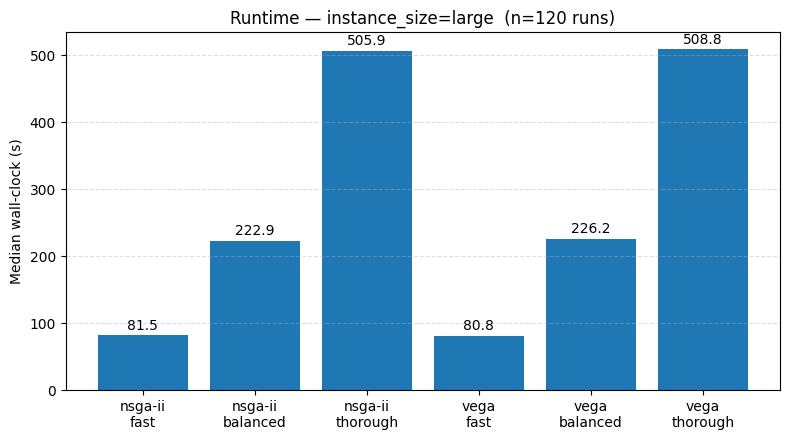

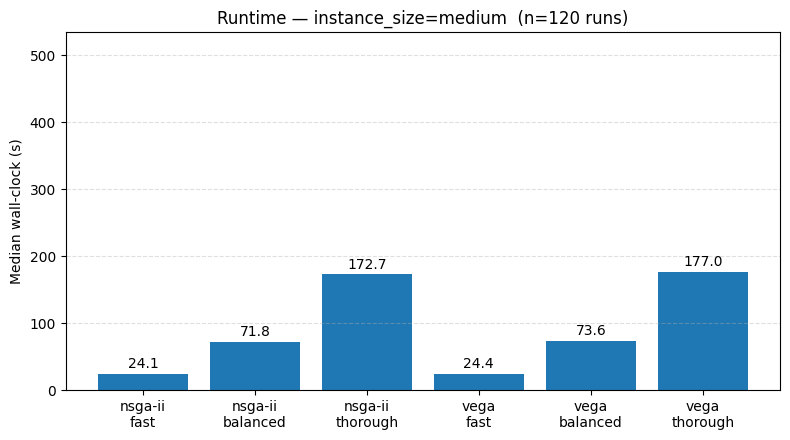

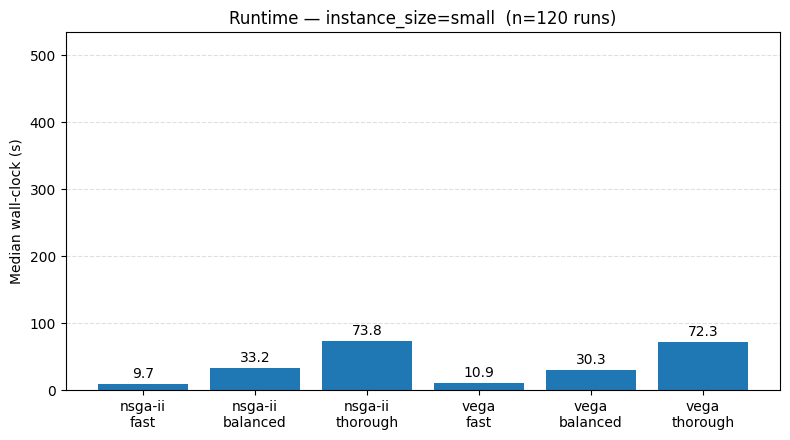

In [12]:

# ---- Aggregate by instance_size (not per instance) ----

# 0) Map instance -> instance_size from _fronts, then attach to runs_w_front
inst_size_map = _fronts[["instance", "instance_size"]].drop_duplicates()
runs_w_size = runs_w_front.merge(inst_size_map, on="instance", how="left")

# sanity: every run should have a size now
missing_sz = runs_w_size["instance_size"].isna().sum()
assert missing_sz == 0, f"{missing_sz} runs missing instance_size mapping."

# 1) Compute size-level summaries directly from runs (true medians)
size_summary = (
    runs_w_size
    .groupby(["instance_size", "algorithm", "preset"], as_index=False)
    .agg(
        wall_clock_s_median = ("wall_clock_s", "median"),
        wall_clock_s_mean   = ("wall_clock_s", "mean"),
        evaluations_median  = ("evaluations", "median"),
        runs                = ("seed", "nunique"),
    )
)

# ---- Plot: median runtime by algorithm/preset for each instance_size ----

alg_order    = ["nsga-ii", "moga", "vega"]   # adjust if needed
preset_order = ["fast", "balanced", "thorough"]
USE_LOG = False  # set True if scales vary a lot

# make a consistent y-limit across sizes
global_max = size_summary["wall_clock_s_median"].max()

# sort sizes numerically if possible
def _as_num(x):
    try:
        return float(x)
    except Exception:
        return x

for sz in sorted(size_summary["instance_size"].unique(), key=_as_num):
    sub = size_summary[size_summary["instance_size"] == sz].copy()
    if sub.empty:
        continue

    # enforce consistent order
    present_algs = [a for a in alg_order if a in sub["algorithm"].unique()]
    present_pre  = [p for p in preset_order if p in sub["preset"].unique()]
    sub["algorithm"] = pd.Categorical(sub["algorithm"], categories=present_algs, ordered=True)
    sub["preset"]    = pd.Categorical(sub["preset"],    categories=present_pre,  ordered=True)
    sub = sub.sort_values(["algorithm", "preset"])

    labels = [f"{a}\n{p}" for a, p in zip(sub["algorithm"].astype(str), sub["preset"].astype(str))]

    fig, ax = plt.subplots(figsize=(8, 4.5))
    x = np.arange(len(sub))
    bars = ax.bar(x, sub["wall_clock_s_median"].to_numpy())

    ax.set_xticks(x, labels)
    ax.set_ylabel("Median wall-clock (s)")
    ax.set_title(f"Runtime — instance_size={sz}  (n={int(sub['runs'].sum())} runs)")
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    if USE_LOG:
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, global_max * 1.05)

    if len(sub) <= 12:
        ax.bar_label(bars, fmt="%.1f", padding=2)

    plt.tight_layout()
    plt.show()



In [13]:
# ---- Clean Pareto fronts: remove sentinel/absurd values + robust outliers ----
import pandas as pd

def _coerce_num(s, comma_decimal=False):
    s = s.astype(str).str.strip()
    if comma_decimal:
        s = s.str.replace(",", ".", regex=False)
    s = s.apply(lambda t: re.sub(r"[^0-9.\-+eE]", "", t))
    return pd.to_numeric(s, errors="coerce")

def clean_fronts(df: pd.DataFrame,
                 fcols=("f1_distance","f2_balance_std"),
                 sentinel_equals=(1e9, 1e12),       # exact sentinel values to drop
                 sentinel_ge=1e8,                   # anything >= this is dropped
                 iqr_k=3.0                          # robust IQR fence per group
                ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Return (clean_df, report) with counts removed by reason & group."""
    f1, f2 = fcols
    gcols = ["instance_size","preset","algorithm"]

    x = df.copy()

    # 1) Numeric
    x[f1] = _coerce_num(x[f1], comma_decimal=False)
    x[f2] = _coerce_num(x[f2], comma_decimal=False)

    # 2) Flag removal reasons
    reasons = {
        "nan":      x[f1].isna() | x[f2].isna(),
        "inf":      ~np.isfinite(x[f1]) | ~np.isfinite(x[f2]),
        "sentinel_eq": False,
        "sentinel_ge": (x[f1].abs() >= sentinel_ge) | (x[f2].abs() >= sentinel_ge),
    }
    # exact sentinel matches (like 1e9)
    if sentinel_equals:
        mask_eq = False
        for val in sentinel_equals:
            mask_eq = mask_eq | (x[f1] == val) | (x[f2] == val)
        reasons["sentinel_eq"] = mask_eq

    # 3) Build initial keep mask
    rm_mask = reasons["nan"] | reasons["inf"] | reasons["sentinel_eq"] | reasons["sentinel_ge"]
    x["_removed_stage"] = np.where(rm_mask, "sentinel/nan/inf", "keep")

    # 4) Robust IQR per group on remaining rows
    keep = x["_removed_stage"].eq("keep")
    def iqr_bounds(s):
        q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3 - q1
        lo = q1 - iqr_k*iqr; hi = q3 + iqr_k*iqr
        return lo, hi

    # compute bounds per group for both metrics
    bounds = []
    for keys, grp in x.loc[keep, gcols + [f1, f2]].groupby(gcols, dropna=False):
        lo1, hi1 = iqr_bounds(grp[f1]); lo2, hi2 = iqr_bounds(grp[f2])
        bounds.append((*keys, lo1, hi1, lo2, hi2))
    bdf = pd.DataFrame(bounds, columns=gcols + [f"{f1}_lo", f"{f1}_hi", f"{f2}_lo", f"{f2}_hi"])

    x = x.merge(bdf, on=gcols, how="left")
    iqr_out = (
        keep
        & (
            (x[f1] < x[f"{f1}_lo"]) | (x[f1] > x[f"{f1}_hi"])
            | (x[f2] < x[f"{f2}_lo"]) | (x[f2] > x[f"{f2}_hi"])
        )
    )
    x.loc[iqr_out, "_removed_stage"] = "iqr_outlier"

    # 5) Report (after marking removals)
    rep = (
        x.groupby(gcols + ["_removed_stage"], dropna=False)
         .size().rename("rows").reset_index()
         .pivot_table(index=gcols, columns="_removed_stage", values="rows", fill_value=0)
         .reset_index()
    )

    # Sum only numeric columns to get a total removed/kept count per group
    num_cols = rep.select_dtypes(include="number").columns
    rep["total"] = rep[num_cols].sum(axis=1)

    # 6) Return cleaned (drop helper bound columns & stage flag)
    drop_cols = [c for c in x.columns if c.endswith("_lo") or c.endswith("_hi")] + ["_removed_stage"]
    cleaned = x[x["_removed_stage"].eq("keep")].drop(columns=drop_cols, errors="ignore")
    return cleaned, rep

# Run cleaning
fronts_clean, clean_report = clean_fronts(_fronts,
                                          fcols=("f1_distance","f2_balance_std"),
                                          sentinel_equals=(1e9,),
                                          sentinel_ge=1e8,
                                          iqr_k=3.0)

print("\n=== Cleaning report by size/preset/algorithm ===")
print(clean_report.to_string(index=False))

# Quick before/after for medium/fast
bf = _fronts[_fronts["instance_size"].str.lower()=="medium"].shape[0]
af = fronts_clean[fronts_clean["instance_size"].str.lower()=="medium"].shape[0]
print(f"\nMedium rows before: {bf:,}  after cleaning: {af:,}")




=== Cleaning report by size/preset/algorithm ===
instance_size   preset algorithm  iqr_outlier   keep  total
        large balanced   nsga-ii          2.0  724.0  726.0
        large balanced      vega          0.0  148.0  148.0
        large     fast   nsga-ii          5.0  598.0  603.0
        large     fast      vega          1.0  164.0  165.0
        large thorough   nsga-ii          0.0  687.0  687.0
        large thorough      vega          0.0  143.0  143.0
       medium balanced   nsga-ii          3.0  965.0  968.0
       medium balanced      vega          0.0  127.0  127.0
       medium     fast   nsga-ii          0.0  760.0  760.0
       medium     fast      vega          0.0  144.0  144.0
       medium thorough   nsga-ii          0.0  884.0  884.0
       medium thorough      vega          0.0  143.0  143.0
        small balanced   nsga-ii          8.0 1348.0 1356.0
        small balanced      vega          0.0  188.0  188.0
        small     fast   nsga-ii         17.0 1441

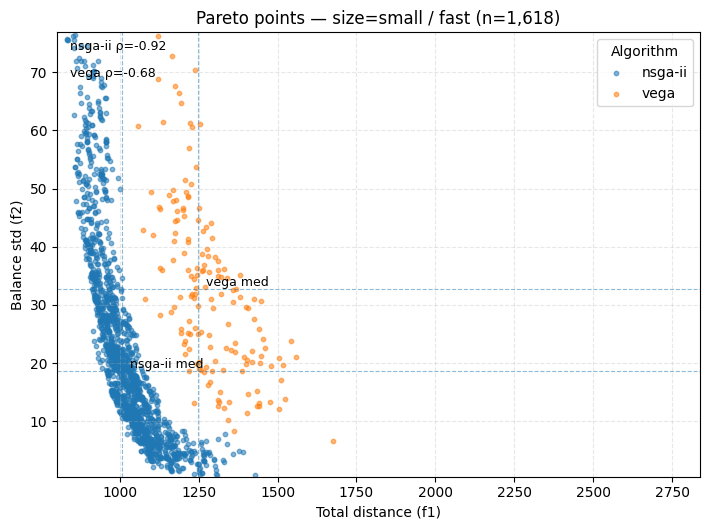

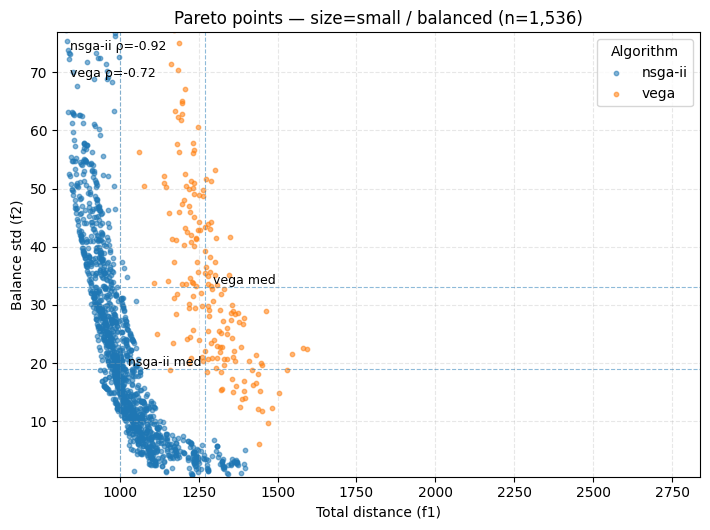

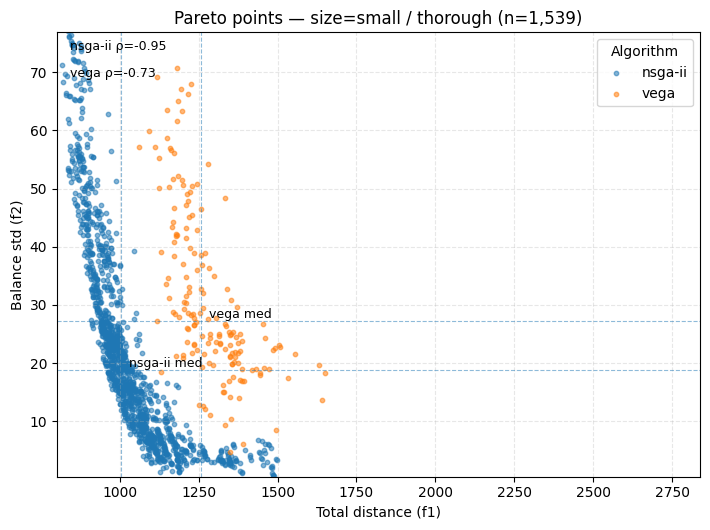

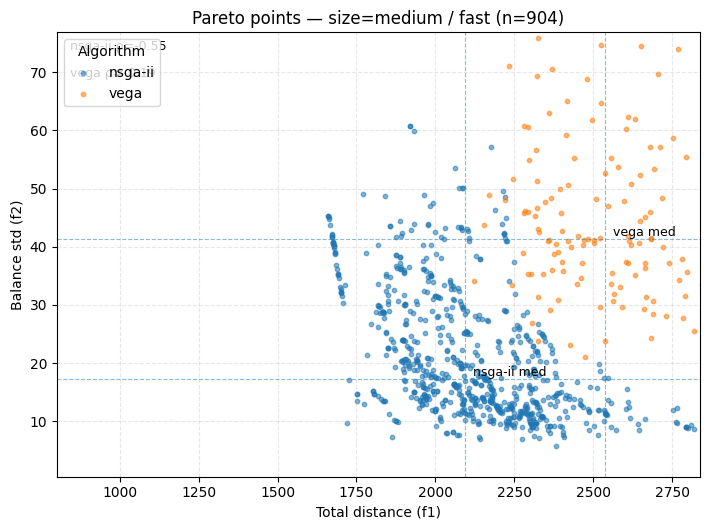

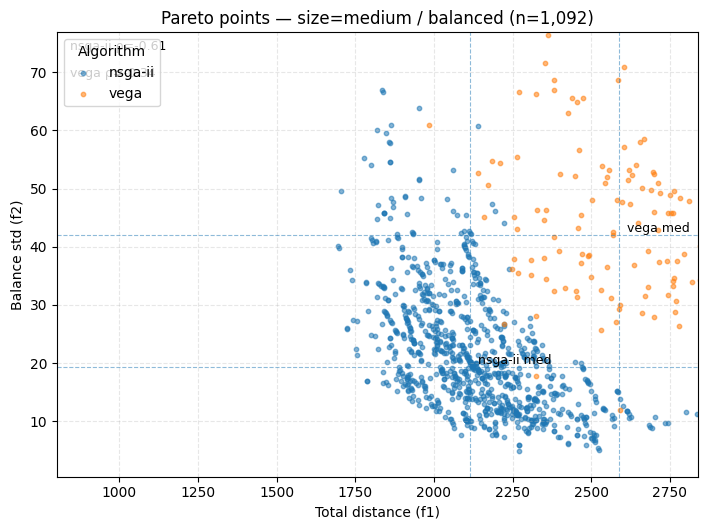

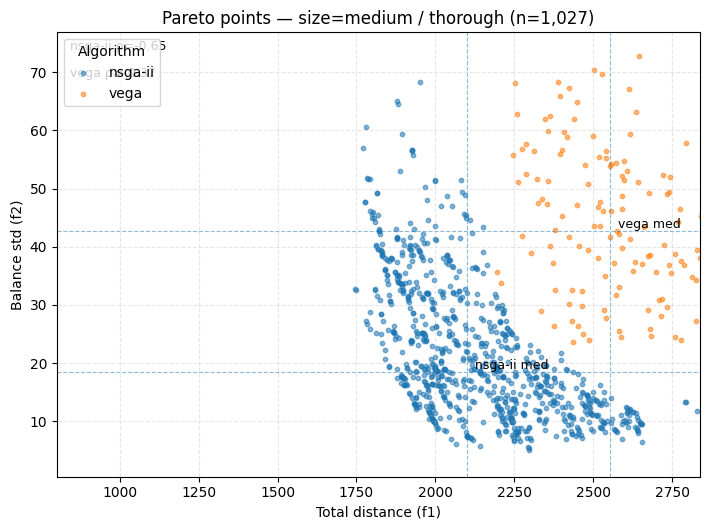

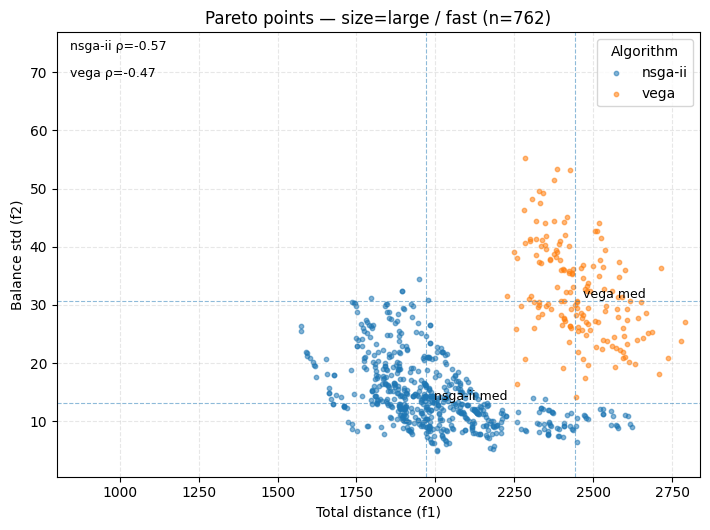

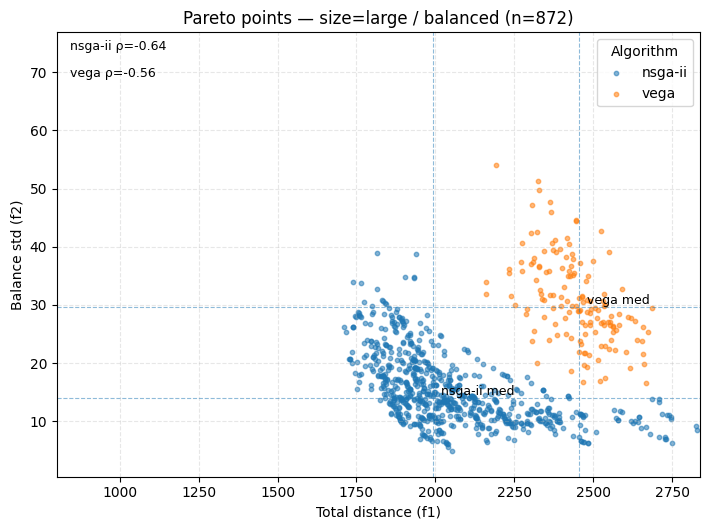

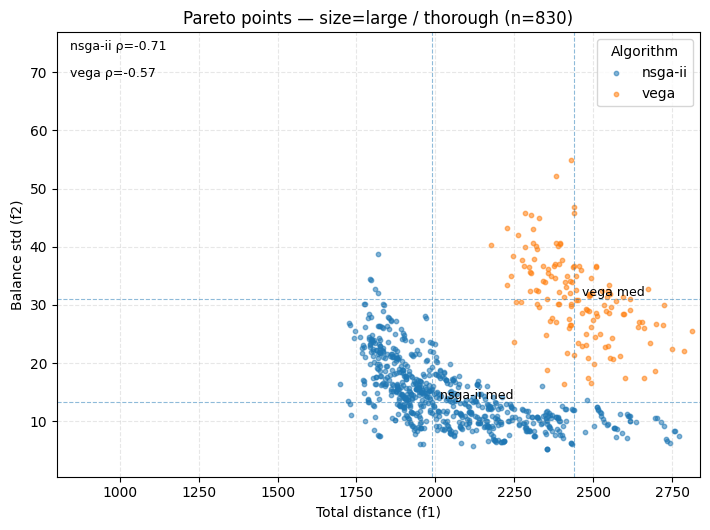

In [14]:
# ---- Enhanced Pareto scatter with medians, global limits, rho, and file export ----

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr  # if not available, comment the rho parts

fronts_plot = fronts_clean.copy()
for col in ["instance_size","preset","algorithm"]:
    fronts_plot[col] = fronts_plot[col].astype(str).str.strip().str.lower()

preferred_sizes   = ["small","medium","large"]
preferred_presets = ["fast","balanced","thorough"]

present_sizes = [s for s in preferred_sizes if s in fronts_plot["instance_size"].unique()]
present_pres  = [p for p in preferred_presets if p in fronts_plot["preset"].unique()]

# 1) Global axis limits for comparability (toggleable)
USE_GLOBAL_LIMITS = True
if USE_GLOBAL_LIMITS:
    f1min, f1max = np.nanpercentile(fronts_plot["f1_distance"], [1, 99])
    f2min, f2max = np.nanpercentile(fronts_plot["f2_balance_std"], [1, 99])
    pad1 = 0.03 * (f1max - f1min)
    pad2 = 0.03 * (f2max - f2min)
    f1min, f1max = f1min - pad1, f1max + pad1
    f2min, f2max = f2min - pad2, f2max + pad2

OUTDIR = Path("figs_fronts"); OUTDIR.mkdir(exist_ok=True)

total_plots = 0
for sz in present_sizes:
    for preset in present_pres:
        sub = fronts_plot[(fronts_plot["instance_size"]==sz) & (fronts_plot["preset"]==preset)]
        if sub.empty:
            continue

        fig, ax = plt.subplots(figsize=(7.2, 5.4))
        # scatter per algorithm
        for algo in sorted(sub["algorithm"].unique()):
            ss = sub[sub["algorithm"]==algo]
            ax.scatter(ss["f1_distance"].to_numpy(),
                       ss["f2_balance_std"].to_numpy(),
                       s=10, alpha=0.55, label=algo)

            # median crosshair + label
            m1 = np.median(ss["f1_distance"])
            m2 = np.median(ss["f2_balance_std"])
            ax.axvline(m1, ls="--", lw=0.8, alpha=0.5)
            ax.axhline(m2, ls="--", lw=0.8, alpha=0.5)
            ax.text(m1, m2, f"  {algo} med", va="bottom", fontsize=9)

            # Spearman rho (optional)
            try:
                rho, _ = spearmanr(ss["f1_distance"], ss["f2_balance_std"])
                ax.text(0.02, 0.96 - 0.06*list(sorted(sub["algorithm"].unique())).index(algo),
                        f"{algo} ρ={rho:0.2f}", transform=ax.transAxes, fontsize=9)
            except Exception:
                pass

        ax.set_xlabel("Total distance (f1)")
        ax.set_ylabel("Balance std (f2)")
        ax.set_title(f"Pareto points — size={sz} / {preset} (n={len(sub):,})")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.legend(title="Algorithm", frameon=True)

        if USE_GLOBAL_LIMITS:
            ax.set_xlim(f1min, f1max)
            ax.set_ylim(f2min, f2max)

        plt.tight_layout()
        # 2) Save figure
        fname = OUTDIR / f"fronts_scatter_size-{sz}_preset-{preset}.png"
        plt.savefig(fname, dpi=160)
        plt.show()

        total_plots += 1




## Convergence & Diversity comparisons
Here we compare algorithms using GD/IGD/spacing (and hypervolume if provided), per preset.


[io] Loaded summary metrics from: /Users/kristina/Dropbox/Mac/Desktop/ACIT4610-project2/ACIT4610-project2/src/results/summary_metrics.csv


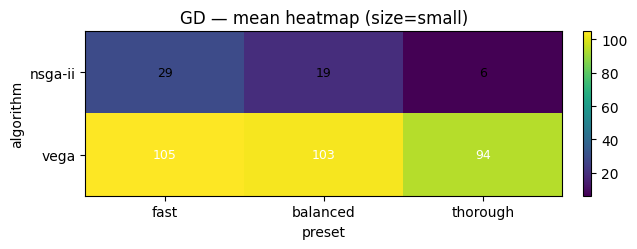

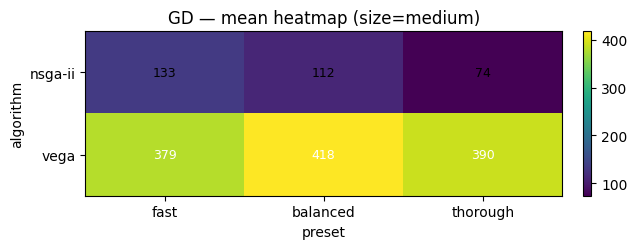

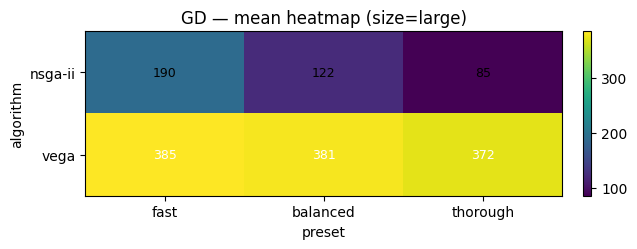

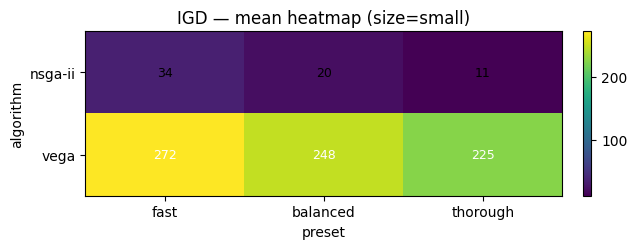

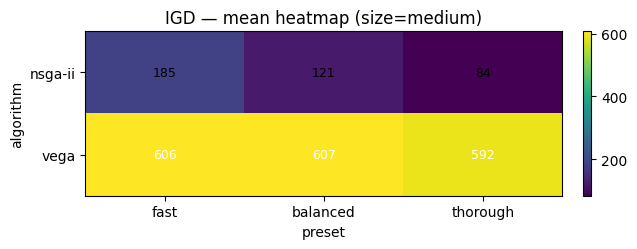

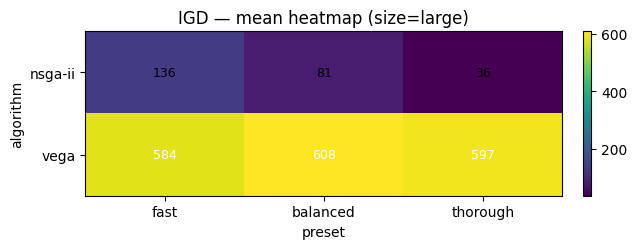

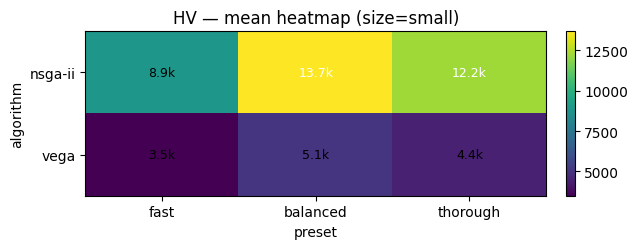

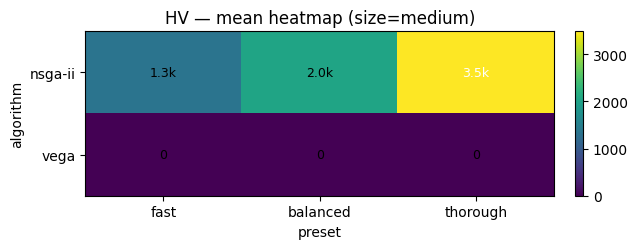

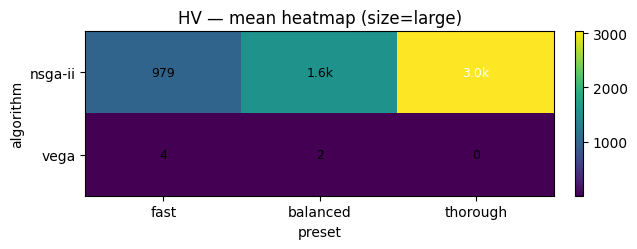

In [15]:
# === Robust loader for summary_metrics + instance_size mapping (no hardcoded paths) ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

# ------- Project root detection -------
def find_project_root(start: Path) -> Path:
    """
    Walk upwards from 'start' to find a directory that looks like the repo root.
    Heuristics: contains 'src' or a '.git' folder.
    """
    cur = start.resolve()
    for parent in [cur, *cur.parents]:
        if (parent / "src").exists() or (parent / ".git").exists():
            return parent
    return start.resolve()  # fallback: use current

HERE = Path.cwd()
PROJECT_ROOT = find_project_root(HERE)

# ------- Candidate locations for results -------
EXP_OUT = os.environ.get("EXP_OUT")  # e.g., <repo>/exp_runner_output
candidates = [
    # 1) If EXP_OUT is set, prefer its 'results' subfolder
    Path(EXP_OUT).expanduser().resolve() / "results" / "summary_metrics.csv" if EXP_OUT else None,
    # 2) Standard locations within the repo
    PROJECT_ROOT / "exp_runner_output" / "results" / "summary_metrics.csv",
    PROJECT_ROOT / "src" / "results" / "summary_metrics.csv",
    # 3) Fallbacks near CWD
    HERE / "summary_metrics.csv",
    HERE / "src" / "results" / "summary_metrics.csv",
]

SUMMARY_PATH = next((p for p in candidates if p and p.exists()), None)
if SUMMARY_PATH is None:
    raise FileNotFoundError(
        "Could not find summary_metrics.csv.\n"
        f"Tried:\n  - " + "\n  - ".join(str(p) for p in candidates if p)
    )

print(f"[io] Loaded summary metrics from: {SUMMARY_PATH}")
df_raw = pd.read_csv(SUMMARY_PATH)

# ------- Column normalization -------
cols = {c.strip().lower(): c for c in df_raw.columns}

def pick(*names, default=None):
    for n in names:
        if n in cols:
            return cols[n]
    return default

COL_INSTANCE = pick("instance","instance_name","instance id","instanceid")
COL_ALG      = pick("algorithm","algo","alg")
COL_PRESET   = pick("preset","config","profile")
COL_GD       = pick("gd","gd mean","gd_mean","gd_mean_all","gd avg","gd_average", default="GD")
COL_IGD      = pick("igd","igd mean","igd_mean","igd_mean_all","igd avg","igd_average", default="IGD")
COL_SPREAD   = pick("spread","spread mean","spread_mean","delta","Δ", default="Spread")
COL_HV       = pick("hv","hypervolume","hv mean","hv_mean", default="HV")

df = df_raw.rename(columns={
    COL_INSTANCE: "instance",
    COL_ALG: "algorithm",
    COL_PRESET: "preset",
    COL_GD: "GD",
    COL_IGD: "IGD",
    COL_SPREAD: "Spread",
    COL_HV: "HV",
})

# ------- Instance → size mapping (your canonical grouping) -------
SIZE_MAP = {
    "A-n32-k5": "small",  "A-n36-k5": "small",
    "B-n68-k9": "medium", "B-n78-k10": "medium",
    "E-n101-k14": "large","M-n151-k12": "large",
}

if "instance" not in df.columns:
    # If the summary is already at size level, try to reuse that column
    for c in df.columns:
        if c.strip().lower() in ("instance size","instance_size","size"):
            df = df.rename(columns={c: "instance_size"})
            break
    else:
        raise ValueError("No 'instance' column to map from, and no size column present.")
else:
    df["instance_size"] = df["instance"].map(SIZE_MAP)

# ------- Canonicalize labels -------
ALG_MAP    = {"nsga-ii":"nsga-ii", "nsga2":"nsga-ii", "vega":"vega"}
PRESET_MAP = {"fast":"fast","balanced":"balanced","thorough":"thorough"}

def _norm(s):
    return (str(s).strip().lower().replace(" ", "").replace("_","-"))

df["algorithm"] = df["algorithm"].map(lambda x: ALG_MAP.get(_norm(x), _norm(x)))
df["preset"]    = df["preset"].map(lambda x: PRESET_MAP.get(_norm(x), _norm(x)))

# ------- Aggregate to size×algorithm×preset means (if still per-instance) -------
metric_cols = [c for c in ["GD","IGD","Spread","HV"] if c in df.columns]
group_cols  = ["instance_size","algorithm","preset"]

if "instance" in df.columns and df["instance"].nunique() > df["instance_size"].nunique():
    agg = (df.groupby(group_cols, as_index=False)[metric_cols].mean())
else:
    # Already aggregated at size level
    agg = df[group_cols + metric_cols].copy()

# ---------- Pretty helpers ----------
def si_fmt(x):
    if x is None or (isinstance(x,float) and (np.isnan(x) or not np.isfinite(x))):
        return "–"
    a = abs(x)
    if a < 1e3:   return f"{x:.0f}"
    if a < 1e6:   return f"{x/1e3:.1f}k"
    if a < 1e9:   return f"{x/1e6:.1f}M"
    if a < 1e12:  return f"{x/1e9:.1f}G"
    if a < 1e15:  return f"{x/1e12:.1f}T"
    if a < 1e18:  return f"{x/1e15:.1f}P"
    return f"{x/1e18:.1f}E"

def si_tick_formatter():
    return FuncFormatter(lambda x, pos: si_fmt(x))

def plot_heatmap_pretty(df_in, metric_col, title_metric=None,
                        presets=("fast","balanced","thorough"),
                        per_panel_scale=True, trim_percentiles=(0,100)):
    sizes = [s for s in ["small","medium","large"] if s in df_in["instance_size"].unique()]
    for sz in sizes:
        sub = df_in[df_in["instance_size"]==sz]
        if sub.empty: continue
        algs = sorted(sub["algorithm"].unique())
        pres = [p for p in presets if p in sub["preset"].unique()]
        if not algs or not pres: continue

        M = np.full((len(algs), len(pres)), np.nan)
        for i,a in enumerate(algs):
            for j,p in enumerate(pres):
                vals = sub.loc[(sub["algorithm"]==a)&(sub["preset"]==p), metric_col].dropna().to_numpy()
                if vals.size: M[i,j] = vals.mean()

        finite = M[np.isfinite(M)]
        if finite.size==0: continue
        lo, hi = (finite.min(), finite.max()) if trim_percentiles==(0,100) else np.percentile(finite, trim_percentiles)
        if not per_panel_scale:
            allvals = df_in[metric_col].to_numpy()
            allvals = allvals[np.isfinite(allvals)]
            if allvals.size:
                lo, hi = (allvals.min(), allvals.max()) if trim_percentiles==(0,100) else np.percentile(allvals, trim_percentiles)
        if hi <= lo: hi = lo + 1e-9

        fig_h = max(2.6, 0.5 + 0.45*len(algs))
        fig, ax = plt.subplots(figsize=(6.5, fig_h))
        im = ax.imshow(M, aspect="auto", interpolation="nearest", vmin=lo, vmax=hi)
        ax.set_yticks(np.arange(len(algs))); ax.set_yticklabels(algs)
        ax.set_xticks(np.arange(len(pres))); ax.set_xticklabels(pres)
        ax.set_xlabel("preset"); ax.set_ylabel("algorithm")
        ttl = title_metric or metric_col
        ax.set_title(f"{ttl} — mean heatmap (size={sz})")

        def _txt_color(v, lo, hi):
            t = 0.0 if hi==lo else (v - lo)/(hi - lo)
            return "white" if t > 0.6 else "black"
        for i in range(len(algs)):
            for j in range(len(pres)):
                v = M[i,j]
                if np.isfinite(v):
                    ax.text(j, i, si_fmt(v), ha="center", va="center",
                            fontsize=9, color=_txt_color(v, lo, hi))

        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.yaxis.set_major_formatter(si_tick_formatter())
        cbar.ax.yaxis.offsetText.set_visible(False)
        cbar.update_ticks()
        plt.tight_layout(); plt.show()

# ---------- Heatmaps from the SAME numbers as in your LaTeX table ----------
plot_heatmap_pretty(agg, "GD",  title_metric="GD")   # lower is better
plot_heatmap_pretty(agg, "IGD", title_metric="IGD")  # lower is better
plot_heatmap_pretty(agg, "HV",  title_metric="HV")   # higher is better
# Optional:
# plot_heatmap_pretty(agg, "Spread", title_metric="Spread")


50% attainment (median) curves